In [1]:
import os
from torch_snippets import *

In [2]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [3]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05), 
                  contrast=(0.95,1.05), 
                  saturation=(0.95,1.05), 
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [4]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(fpath.parent).split('\\')[-1]
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

2021-11-07 10:52:05.645 | INFO     | torch_snippets.paths:inner:24 - 27558 files found at cell_images/*/*.png
2021-11-07 10:52:05.863 | INFO     | __main__:__init__:6 - 20668
2021-11-07 10:52:05.864 | INFO     | __main__:__init__:6 - 6890


In [7]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [8]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

EPOCH: 1.000	trn_loss: 0.247	trn_acc: 0.905	val_loss: 0.161	val_acc: 0.948	(90.83s - 363.31s remaining)
EPOCH: 2.000	trn_loss: 0.169	trn_acc: 0.946	val_loss: 0.177	val_acc: 0.947	(182.62s - 273.92s remaining)
EPOCH: 3.000	trn_loss: 0.162	trn_acc: 0.948	val_loss: 0.156	val_acc: 0.944	(282.19s - 188.13s remaining)
EPOCH: 4.000	trn_loss: 0.154	trn_acc: 0.950	val_loss: 0.153	val_acc: 0.951	(385.86s - 96.46s remaining)
EPOCH: 5.000	trn_loss: 0.149	trn_acc: 0.950	val_loss: 0.152	val_acc: 0.952	(490.11s - 0.00s remaining)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 642.27it/s]


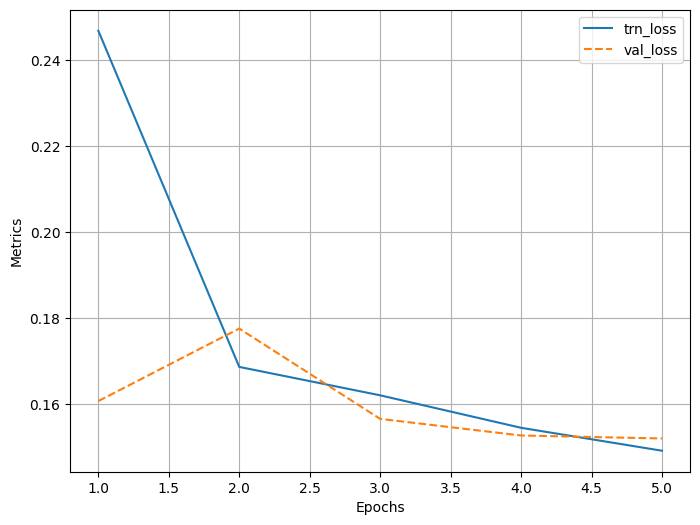

In [11]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
log.plot_epochs(['trn_loss', 'val_loss'])

In [12]:
from torchsummary import summary
summary(model, input_size=(3,128,128), device=device);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Dropout: 3-1                 --
|    |    └─Conv2d: 3-2                  1,792
|    |    └─ReLU: 3-3                    --
|    |    └─BatchNorm2d: 3-4             128
|    |    └─MaxPool2d: 3-5               --
|    └─Sequential: 2-2                   --
|    |    └─Dropout: 3-6                 --
|    |    └─Conv2d: 3-7                  36,928
|    |    └─ReLU: 3-8                    --
|    |    └─BatchNorm2d: 3-9             128
|    |    └─MaxPool2d: 3-10              --
|    └─Sequential: 2-3                   --
|    |    └─Dropout: 3-11                --
|    |    └─Conv2d: 3-12                 73,856
|    |    └─ReLU: 3-13                   --
|    |    └─BatchNorm2d: 3-14            256
|    |    └─MaxPool2d: 3-15              --
|    └─Sequential: 2-4                   --
|    |    └─Dropout: 3-16                --
|    |    └─C

In [16]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [20]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [77]:
SZ = 128
def upsampleHeatmap(hmap, img):
    m,M = hmap.min(), hmap.max()
    hmap = 255 * ((hmap-m) / (M-m))
    hmap = np.uint8(hmap)
    hmap = cv2.resize(hmap, (SZ,SZ))
    hmap = cv2.applyColorMap(255-hmap, cv2.COLORMAP_JET)
    hmap = np.uint8(hmap)
    hmap = np.uint8(hmap*0.7 + img*0.3)
    return hmap

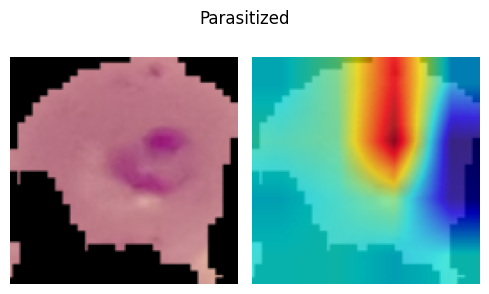

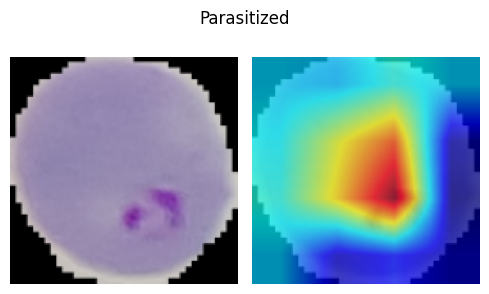

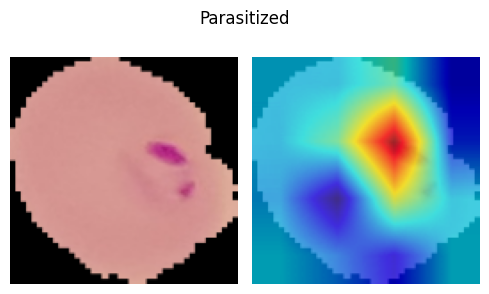

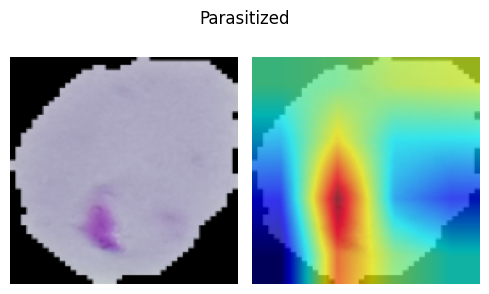

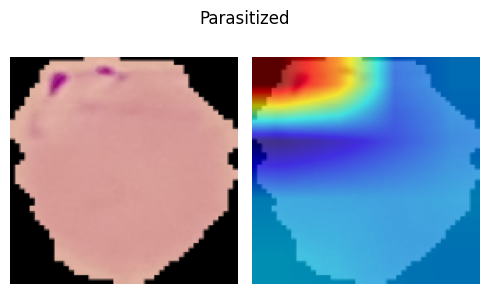

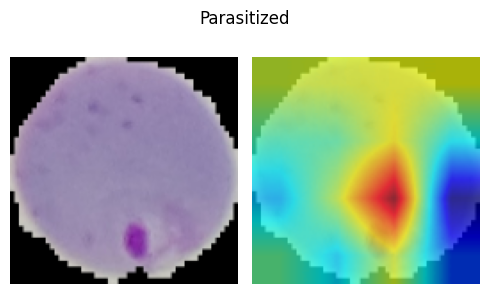

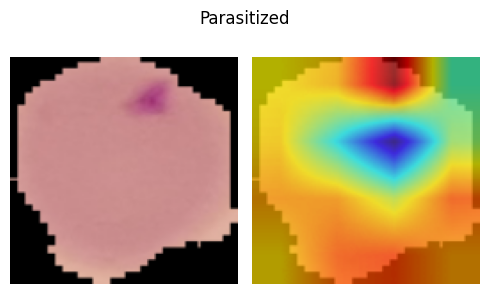

In [79]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)